# CandyCare

__PML WS 2021/22__ <br>
_by Julian Mierisch and Anna Martynova_

### Goals
1. Make Model which predicts which win percentage a given new candy has
2. Predict which combination has highest win propability
3. Cluster data?

### Import packages and data

In [197]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [24]:
candyData = pd.read_csv('candy-data.csv')
candyData

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


### Data exploration 

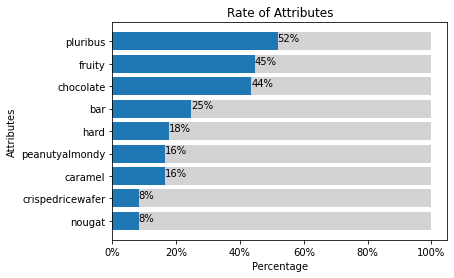

In [209]:
#Show distribution of candy attributes in dataset
candyAttributes = candyData.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
data = {'Attributes': candyAttributes.columns, 'Values': candyAttributes.sum()/len(candyAttributes)}  
candyAttrPercent = pd.DataFrame(data).reset_index().drop(columns=['index']).sort_values(by=['Values'])

fig, ax = plt.subplots()
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")
plt.barh(candyAttrPercent['Attributes'], candyAttrPercent['Values'])
for index, value in enumerate(candyAttrPercent['Values']):
    plt.text(value, index, str("{:.0%}".format(value)))
plt.barh(candyAttrPercent['Attributes'], 1-candyAttrPercent['Values'], left=candyAttrPercent['Values'], color="lightgrey")
plt.title('Rate of Attributes')
plt.ylabel('Attributes')
plt.xlabel('Percentage')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()